In [2]:
import numpy as np
import random
import re
from tokenizers import Tokenizer
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [4]:
print(f"PyTorch版本: {torch.__version__}")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

PyTorch版本: 2.6.0
使用设备: mps


In [5]:
data_size = 300000
loaded_model_path = f"models/bpe_model_{data_size}.json"


def load_bpe_model(model_path):
    tokenizer = Tokenizer.from_file(model_path)

    tokenizer.pad_token = "<pad>"
    tokenizer.pad_token_id = tokenizer.token_to_id("<pad>")

    tokenizer.bos_token = "<bos>"
    tokenizer.bos_token_id = tokenizer.token_to_id("<bos>")

    tokenizer.eos_token = "<eos>"
    tokenizer.eos_token_id = tokenizer.token_to_id("<eos>")

    tokenizer.unk_token = "<unk>"
    tokenizer.unk_token_id = tokenizer.token_to_id("<unk>")

    return tokenizer


tokenizer = load_bpe_model(loaded_model_path)

In [6]:
class Head(nn.Module):
    def __init__(self, n_embd, head_size, masking=True):
        super().__init__()
        self.query = nn.Linear(n_embd, head_size)
        self.key = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)
        self.masking = masking
        if masking:
            self.register_buffer("mask", torch.tril(torch.ones(512, 512)))

    def forward(self, x, encoder_output=None, src_padding_mask=None):
        # x: (B, T, n_embd)
        # encoder_output: (B, T1, n_embd)
        # src_padding_mask: (B, T)

        B, T = x.shape[0], x.shape[1]

        q = self.query(x)  # (B, T, head_size)
        if encoder_output is not None:
            # CROSS-ATTENTION
            # encoder_output: (B, T1, n_embd)
            k = self.key(encoder_output)  # (B, T1, head_size)
            v = self.value(encoder_output)  # (B, T1, head_size)
        else:
            # SELF-ATTENTION
            k = self.key(x)
            v = self.value(x)
        attn = q @ k.transpose(-2, -1)  # (B, T, T) or (B, T, T1)
        attn = attn * (k.size(-1) ** -0.5)
        if self.masking:
            attn = attn.masked_fill(self.mask[:T, :T] == 0, float('-inf'))

        if src_padding_mask is not None:
            if encoder_output is not None:
                attn = attn.masked_fill(src_padding_mask.unsqueeze(1), float('-inf'))
            else:
                attn = attn.masked_fill(src_padding_mask.unsqueeze(1).expand(-1, T, -1), float('-inf'))

        attn_weights = F.softmax(attn, dim=-1)  # (B, T, T)

        out = attn_weights @ v  # (B, T, head_size)
        return out, attn_weights


class MultiHead(nn.Module):
    def __init__(self, n_embd, head_size, n_head, masking=True):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embd, head_size, masking) for _ in range(n_head)])
        self.fc = nn.Linear(n_head * head_size, n_embd)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, encoder_output=None, src_padding_mask=None, return_attn=False):
        attn_outs = [head(x, encoder_output, src_padding_mask) for head in self.heads]
        attns = [out[0] for out in attn_outs]
        out = torch.cat(attns, dim=-1)  # (B, T, n_head * head_size)
        out = self.dropout(self.fc(out))  # (B, T, n_embd)
        if return_attn:
            attn_weights = [out[1] for out in attn_outs]
            return out, attn_weights
        else:
            return out


class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class EncoderBlock(nn.Module):
    def __init__(self, n_embd, head_size, n_head, dropout=0.3):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.sa = MultiHead(n_embd, head_size, n_head, masking=False)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ff = FeedForward(n_embd, dropout)

    def forward(self, x, src_padding_mask=None, return_attn=False):
        if return_attn:
            sa_out, attn_weights = self.sa(self.ln1(x), src_padding_mask=src_padding_mask, return_attn=True)
        else:
            sa_out = self.sa(self.ln1(x), src_padding_mask=src_padding_mask)
        x = x + sa_out
        x = x + self.ff(self.ln2(x))
        return (x, attn_weights) if return_attn else x


class DecoderBlock(nn.Module):
    def __init__(self, n_embd, head_size, n_head, dropout=0.3):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.sa = MultiHead(n_embd, head_size, n_head, masking=True)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ca = MultiHead(n_embd, head_size, n_head, masking=False)
        self.ln3 = nn.LayerNorm(n_embd)
        self.ff = FeedForward(n_embd, dropout)

    def forward(self, x, encoder_output, src_padding_mask=None, return_attn=False):
        # x: (B, T, n_embd)
        # encoder_output: (B, T1, n_embd)
        x = x + self.sa(self.ln1(x))
        if return_attn:
            ca_out, attn_weights = self.ca(self.ln2(x), encoder_output, src_padding_mask, return_attn=True)
        else:
            ca_out = self.ca(self.ln2(x), encoder_output, src_padding_mask)
            attn_weights = None
        x = x + ca_out
        x = x + self.ff(self.ln3(x))
        return (x, attn_weights) if return_attn else x


class Model(nn.Module):
    def __init__(self, n_embd, n_head, n_layers, vocab_size, dropout=0.3):
        super().__init__()
        head_size = n_embd // n_head
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding = nn.Embedding(512, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.encoder_blocks = nn.ModuleList([EncoderBlock(n_embd, head_size, n_head, dropout) for _ in range(n_layers)])
        self.decoder_blocks = nn.ModuleList([DecoderBlock(n_embd, head_size, n_head, dropout) for _ in range(n_layers)])
        self.ln_in = nn.LayerNorm(n_embd)
        self.ln_tgt_in = nn.LayerNorm(n_embd)
        self.ln_f = nn.LayerNorm(n_embd)

    def encode(self, src, return_attn=False):
        B, T1 = src.shape
        src_padding_mask = (src == 0).to(src.device)  # (B, T1)

        # ENCODER
        tok_emb = self.token_embedding(src)  # (B, T1, n_embd)
        pos = torch.arange(0, T1, device=src.device).unsqueeze(0).repeat(B, 1)  # (B, T1)
        pos_emb = self.pos_embedding(pos)  # (B, T1, n_embd)
        x = self.ln_in(tok_emb + pos_emb)  # (B, T1, n_embd)
        x = self.dropout(x)

        self_attns = []
        # Pass padding mask to each encoder block
        for encoder_block in self.encoder_blocks:
            if return_attn:
                x, attn_weights = encoder_block(x, src_padding_mask, return_attn=True)
                self_attns.append(attn_weights)
            else:
                x = encoder_block(x, src_padding_mask)
        encoder_output = self.ln_f(x)  # (B, T1, n_embd)
        return (encoder_output, src_padding_mask, self_attns) if return_attn else (encoder_output, src_padding_mask)

    def decode(self, tgt, encoder_output, src_padding_mask, return_attn=False):
        B, T2 = tgt.shape
        tgt_tok_emb = self.token_embedding(tgt)  # (B, T2, n_embd)
        pos = torch.arange(0, T2, device=tgt.device).unsqueeze(0).repeat(B, 1)  # (B, T2)
        pos_emb = self.pos_embedding(pos)  # (B, T2, n_embd)
        x = self.ln_tgt_in(tgt_tok_emb + pos_emb)  # (B, T2, n_embd)
        x = self.dropout(x)

        cross_attns = []
        for decoder_block in self.decoder_blocks:
            if return_attn:
                x, attn_weights = decoder_block(x, encoder_output, src_padding_mask, return_attn=True)
                cross_attns.append(attn_weights)
            else:
                x = decoder_block(x, encoder_output, src_padding_mask)
        x = self.ln_f(x)  # (B, T2, n_embd)
        logits = F.linear(x, self.token_embedding.weight)  # (B, T2, tgt_vocab_size)
        return (logits, cross_attns) if return_attn else logits

    def forward(self, src, tgt):
        # src: (B, T1), tgt: (B, T2)
        B = src.shape[0]
        encoder_output, src_padding_mask = self.encode(src)
        decoder_target = torch.cat([tgt[:, 1:], torch.zeros(B, 1, dtype=tgt.dtype, device=tgt.device)], dim=1)
        logits = self.decode(tgt, encoder_output, src_padding_mask)  # (B, T2, tgt_vocab_size)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), decoder_target.view(-1), ignore_index=0)
        return logits, loss

In [7]:
def load_checkpoint(path, device):
    checkpoint = torch.load(path, map_location=device)

    # 重建模型
    model = Model(**checkpoint['model_config'])
    model = model.to(device)

    # 将模型状态移动到正确的设备
    if device.type == 'cuda':
        checkpoint['model_state_dict'] = {k: v.to(device) for k, v in checkpoint['model_state_dict'].items()}

    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint

In [8]:
def top_k_sample(model, src, sos_token, eos_token, max_len=50, device='cpu', top_k=5, temperature=0.5):
    model.eval()
    with torch.no_grad():
        src = src.to(device)
        B, T = src.shape[0], src.shape[1]
        encoder_output, src_padding_mask = model.encode(src)
        sequences = torch.ones(B, 1, dtype=torch.long, device=device) * sos_token

        for _ in range(max_len):
            logits = model.decode(sequences, encoder_output, src_padding_mask)
            logits = logits[:, -1, :] / temperature  # (B, vocab_size)
            topk_logits, top_k_indices = torch.topk(logits, k=min(top_k, logits.size(-1)))  # (B, k)
            probs = F.softmax(topk_logits, dim=-1)  # (B, k)
            next_token_idx = torch.multinomial(probs, num_samples=1)
            next_token = torch.gather(top_k_indices, 1, next_token_idx)
            sequences = torch.cat([sequences, next_token], dim=1)
            if (next_token == eos_token).all():
                break
    model.train()
    return sequences


def beam_search(model, src, sos_token, eos_token, beam_width=5, max_len=50, device='cpu'):
    model.eval()
    with torch.no_grad():
        src = src.to(device)
        B, T = src.shape[0], src.shape[1]
        encoder_output, src_padding_mask = model.encode(src)
        outputs = []
        for batch_idx in range(B):
            enc_output = encoder_output[batch_idx:batch_idx + 1]  # (1, T1, n_embd)
            src_mask = src_padding_mask[batch_idx:batch_idx + 1]  # (1, T1)
            beams = [(torch.ones(1, 1, dtype=torch.long, device=device) * sos_token, 0.0)]
            for _ in range(max_len):
                new_beams = []
                for seq, log_prob in beams:
                    if seq[0, -1] == eos_token:
                        new_beams.append((seq, log_prob))
                        continue
                    logits = model.decode(seq, enc_output, src_mask)
                    logits = logits[:, -1, :]  # (1, vocab_size)
                    probs = F.softmax(logits, dim=-1)
                    topk_probs, topk_indices = torch.topk(probs, beam_width)
                    for i in range(beam_width):
                        token_id = topk_indices[0, i].item()
                        log_prob = topk_probs[0, i].item()
                        new_seq = torch.cat([seq, torch.tensor([[token_id]], device=device)], dim=1)
                        new_log_prob = log_prob + log_prob
                        new_beams.append((new_seq, new_log_prob))
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
                if all(seq[0, -1].item() == eos_token for seq, _ in beams):
                    break
            best_seq = max(beams, key=lambda x: x[1])[0].squeeze(0)
            outputs.append(best_seq)
    model.train()
    return outputs


def translate(model, seqs, max_len, device, tokenizer, method='beam_search', **kwargs):
    B = len(seqs)
    inputs = torch.zeros(B, max_len, dtype=torch.long, device=device)
    for i, seq in enumerate(seqs):
        encoded = [tokenizer.bos_token_id] + tokenizer.encode(seq).ids + [tokenizer.eos_token_id]
        length = min(len(encoded), max_len)
        inputs[i, :length] = torch.tensor(encoded[:length], dtype=torch.long, device=device)
    if method == 'top_k_sample':
        outputs = top_k_sample(model, inputs, tokenizer.bos_token_id, tokenizer.eos_token_id, max_len=max_len, device=device, **kwargs)
    elif method == 'beam_search':
        outputs = beam_search(model, inputs, tokenizer.bos_token_id, tokenizer.eos_token_id, max_len=max_len, device=device, **kwargs)
    else:
        raise ValueError(f"Invalid method: {method}")
    results = []
    for i in range(B):
        result = tokenizer.decode(outputs[i].tolist())
        if '<eos>' in result:
            result = result.split('<eos>')[0]  # Remove everything after <eos>
        # result = result.replace('<eos>', '').replace('<sos>', '')
        results.append(result)
    return results

In [9]:
path = "checkpoint_star/summary_checkpoint_300k_128.pt"
model, checkpoint = load_checkpoint(path, device)

In [10]:
# Read English and Chinese training data
with open('data/gigaword_input_300000.txt', 'r', encoding='utf-8') as f_input, open('data/gigaword_summary_300000.txt', 'r', encoding='utf-8') as f_summary:
    input_lines = f_input.readlines()
    summary_lines = f_summary.readlines()

In [11]:
import random

random_indices = random.sample(range(len(input_lines)), 5)
seqs = [input_lines[i].strip() for i in random_indices]
refs = [summary_lines[i].strip() for i in random_indices]

args = [{
    "method": "top_k_sample",
    "top_k": 5,
    "temperature": 0.5
}, {
    "method": "top_k_sample",
    "top_k": 10,
    "temperature": 0.7
}, {
    "method": "beam_search",
    "beam_width": 3
}
]

# Print all configurations
for i, arg in enumerate(args):
    print(f"Config {i+1}: " + ", ".join([f"{k}: {v}" for k, v in arg.items()]))
print("=" * 100)

# Batch translate with all configurations
all_translations = []
for arg in args:
    translations = translate(model, seqs, 50, device, tokenizer, **arg)
    all_translations.append(translations)

# Print by source text
for i, (src, ref) in enumerate(zip(seqs, refs)):
    print(f"Text {i+1}: {src}")
    print(f"Reference: {ref}")

    for j, translations in enumerate(all_translations):
        print(f"Config {j+1}: {translations[i]}")

    print("-" * 80)

Config 1: method: top_k_sample, top_k: 5, temperature: 0.5
Config 2: method: top_k_sample, top_k: 10, temperature: 0.7
Config 3: method: beam_search, beam_width: 3
Text 1: russia will provide military equipment to armenia and train its police and troops under an accord signed in yerevan wednesday .
Reference: russia to modernize train armenian military
Config 1: russia to train armenian troops in yerevan security deal
Config 2: russia to train armenian police troops in yerevan agreement
Config 3: russia to train armenian police in yerevan
--------------------------------------------------------------------------------
Text 2: crisis club leeds united were reported friday to be set to make gordon strachan their new manager as soon as they reach agreement with southampton over his pay-off .
Reference: southampton boss strachan set for leeds
Config 1: southampton sign leeds to strachan strachan deal strachan
Config 2: strachan poised to make leeds job southampton deal strachan strachan
Co

# Visualize


In [19]:
def visualize_all_attention(src_tokens, tgt_tokens, cross_attns, cmap="viridis"):
    num_layers = len(cross_attns)
    num_heads = len(cross_attns[0])

    for layer in range(num_layers):
        # 创建一个包含所有head的大图
        fig, axes = plt.subplots(1, num_heads, figsize=(8 * num_heads, 6))

        for head in range(num_heads):
            # 获取第layer层第head的注意力矩阵
            attn_matrix = cross_attns[layer][head][0].cpu().detach().numpy()

            # 在对应的子图上绘制热力图
            sns.heatmap(attn_matrix, xticklabels=src_tokens, yticklabels=tgt_tokens,
                        cmap=cmap, cbar_kws={'label': 'Attention Score'}, ax=axes[head])

            axes[head].set_xlabel('Source Tokens')
            axes[head].set_ylabel('Target Tokens')
            axes[head].set_title(f'Layer {layer+1} - Head {head+1}')

        plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
        plt.show()


def visualize_all_steps_attention(src_tokens, tgt_tokens, steps_cross_attns, cmap="viridis", max_steps_to_plot=16):
    import math
    num_steps = len(steps_cross_attns)
    if num_steps == 0:
        print("No steps to visualize.")
        return
    num_layers = len(steps_cross_attns[0])
    num_heads = len(steps_cross_attns[0][0])

    steps_to_plot = min(num_steps, max_steps_to_plot)

    # Determine subplot grid layout
    ncols = math.ceil(math.sqrt(steps_to_plot))
    nrows = math.ceil(steps_to_plot / ncols)

    for layer in range(num_layers):
        for head in range(num_heads):
            # Create a new figure for each layer-head combination
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)  # Ensure axes is always 2D
            fig.suptitle(f'Layer {layer+1} - Head {head+1} - Attention Evolution (Up to {steps_to_plot} steps)', fontsize=16)

            for step in range(steps_to_plot):
                # Calculate subplot position
                row_idx = step // ncols
                col_idx = step % ncols
                ax = axes[row_idx, col_idx]

                # Get attention matrix for the current step, layer, head
                # Shape: [1, T_tgt_max, T_src] -> [T_tgt_max, T_src]
                attn_matrix_full = steps_cross_attns[step][layer][head][0].cpu().detach().numpy()

                # Slice target tokens and attention matrix for the current step
                current_tgt_tokens = tgt_tokens[:step + 1]
                # attn_matrix_step shape: [step + 1, T_src]
                attn_matrix_step = attn_matrix_full[:step + 1, :]

                if not current_tgt_tokens:  # Skip if no target tokens yet (shouldn't happen if step starts at 0)
                    continue

                # Plot heatmap for the current step
                sns.heatmap(attn_matrix_step, xticklabels=src_tokens, yticklabels=current_tgt_tokens,
                            cmap=cmap, cbar=False, ax=ax)  # Turn off individual color bars for clarity

                ax.set_xlabel('Source Tokens')
                ax.set_ylabel('Target Tokens')
                ax.set_title(f'Step {step+1}')
                # Rotate x-axis labels if they overlap
                ax.tick_params(axis='x', rotation=90)
                ax.tick_params(axis='y', rotation=0)

            # Remove empty subplots if steps_to_plot < nrows * ncols
            for i in range(steps_to_plot, nrows * ncols):
                fig.delaxes(axes.flatten()[i])

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent title overlap
            plt.show()


def decode_token(t, itos):
    if isinstance(t, int) and t != -1:
        return itos[t]
    elif isinstance(t, torch.Tensor) and t.item() != -1:
        return itos[t.item()]
    else:
        return 'X'

['<sos>', 'paris', 'as', 'the', 'economic', 'crisis', 'deepens', 'and', 'widens', ',', 'the', 'world', 'has', 'been', 'searching', 'for', 'historical', 'analog', 'ies', 'to', 'help', 'us', 'understand', 'what', 'has', 'been', 'happening', '.', '<eos>']


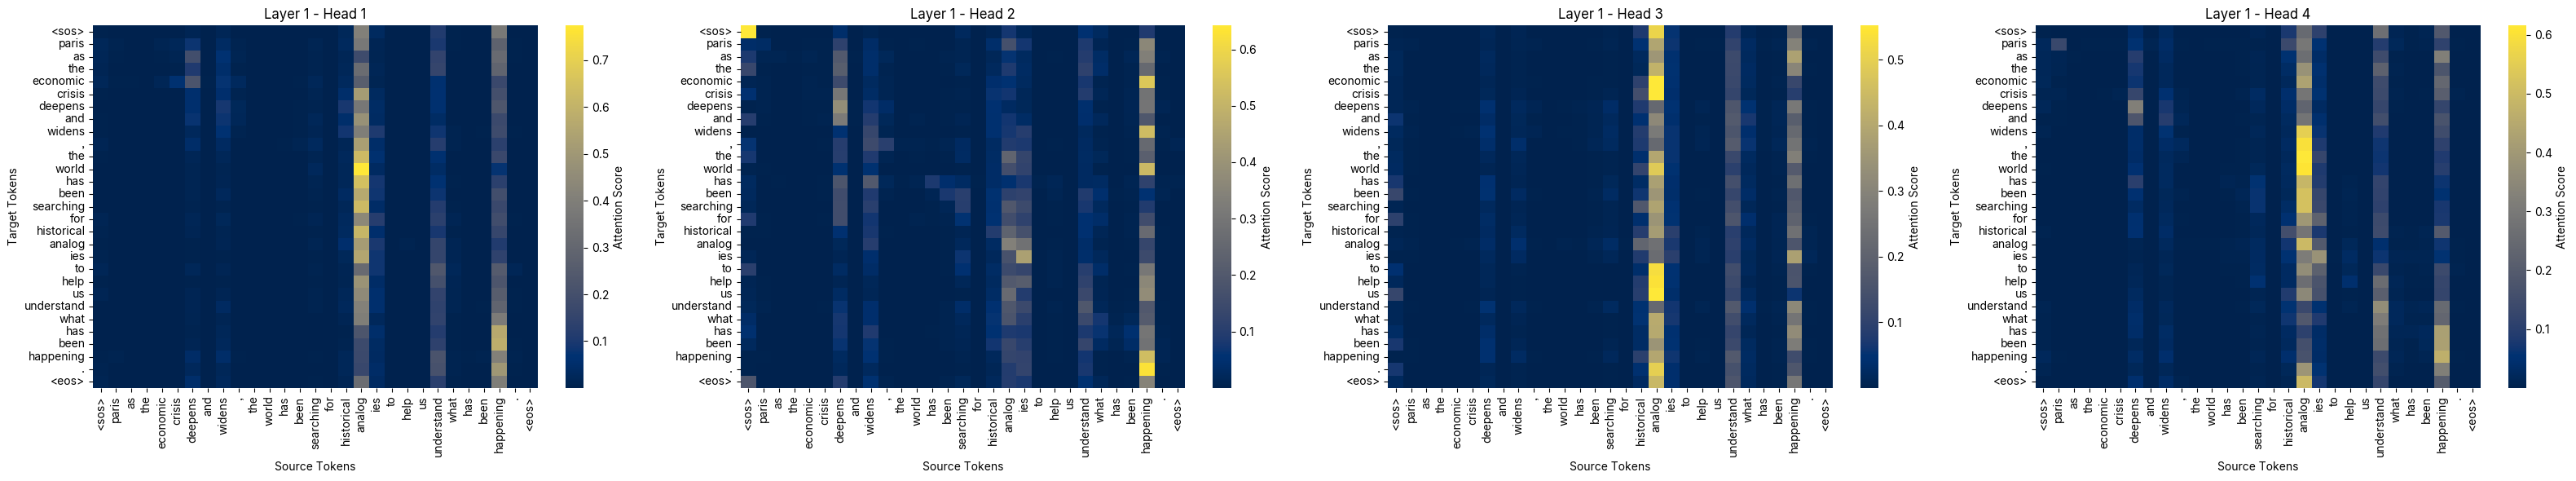

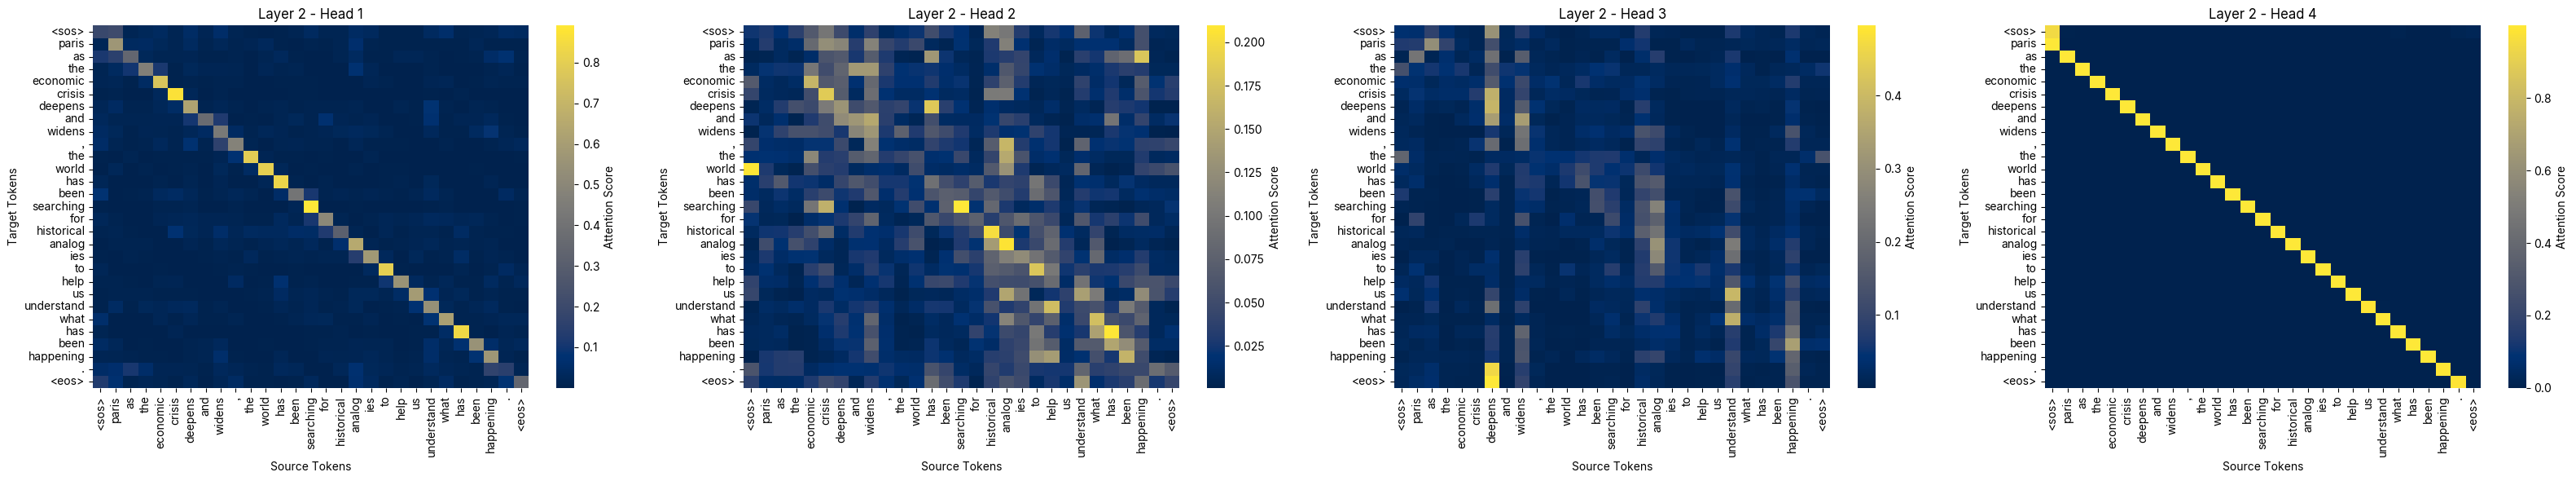

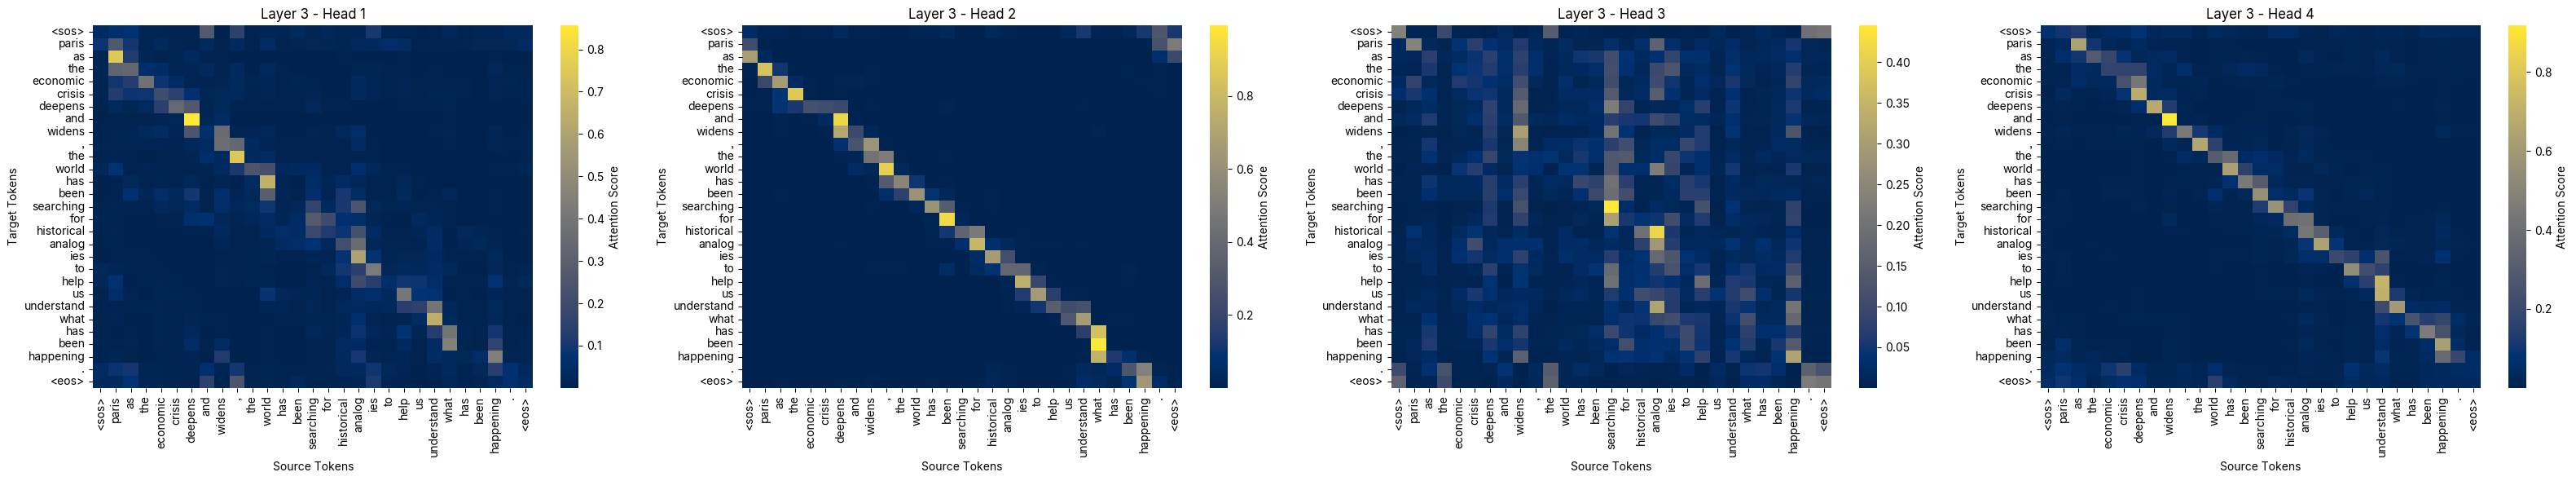

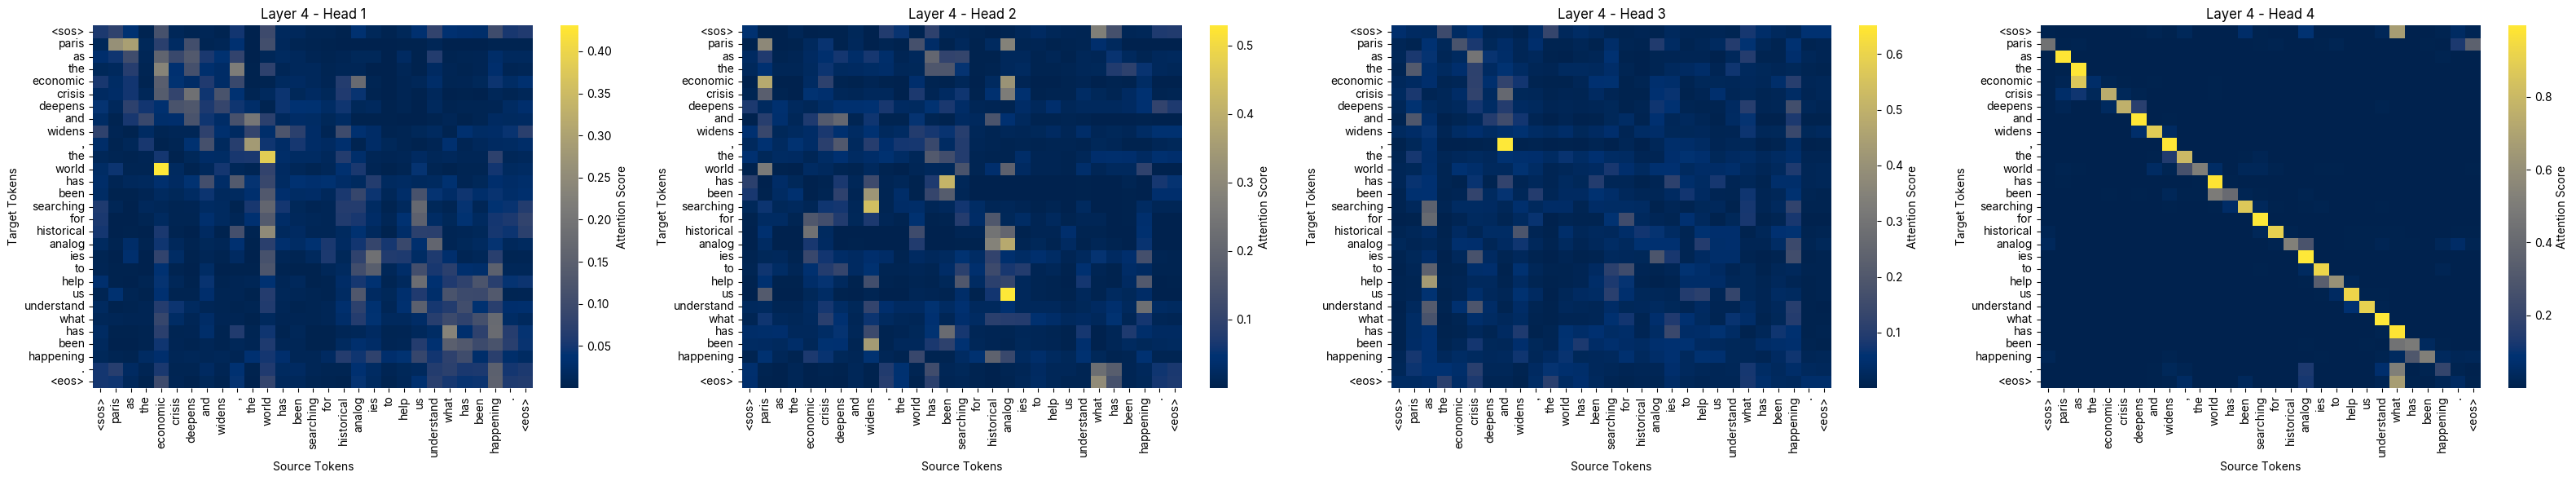

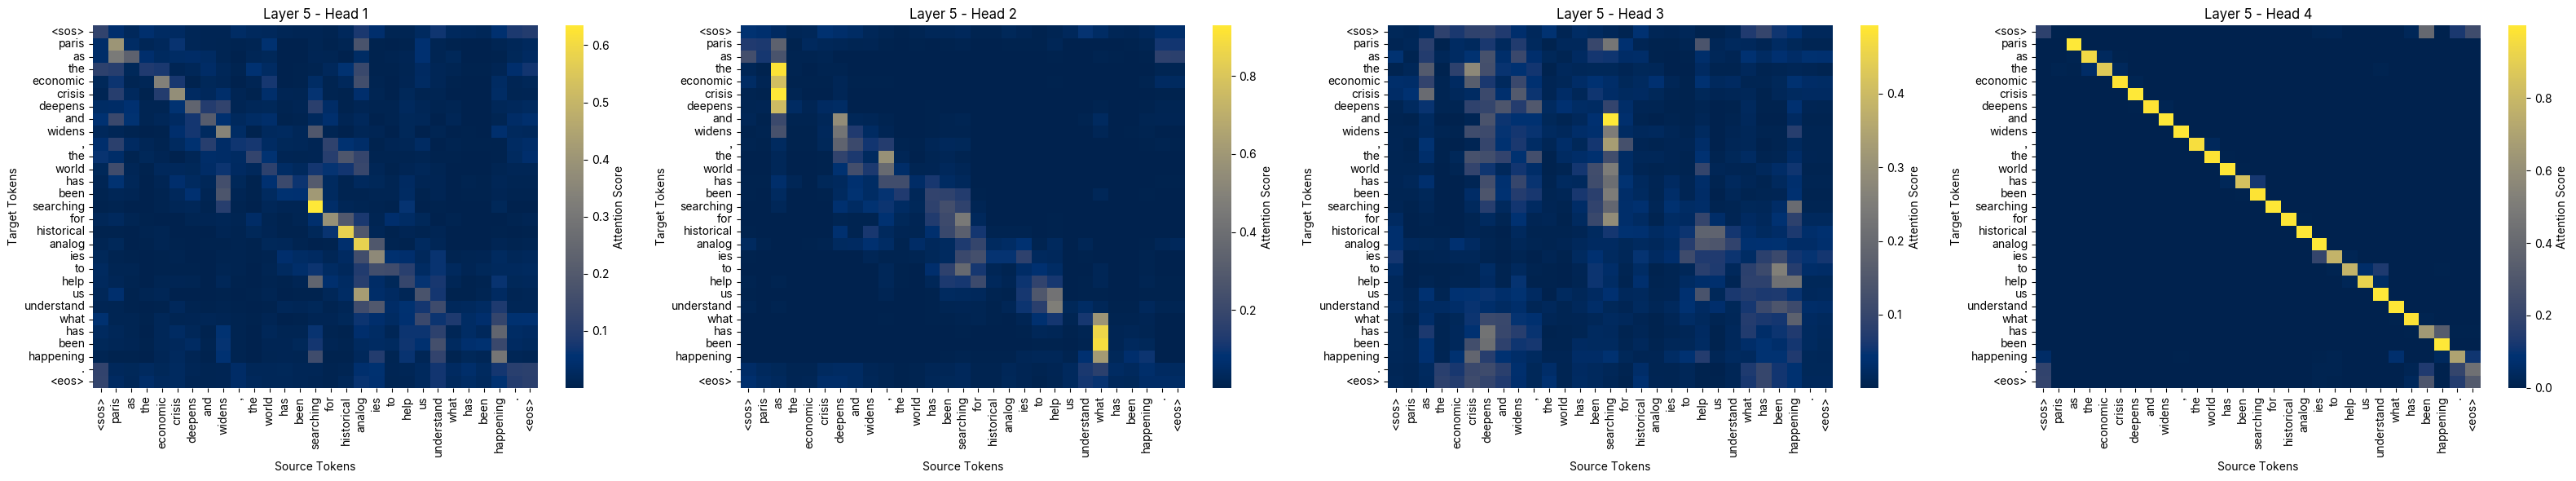

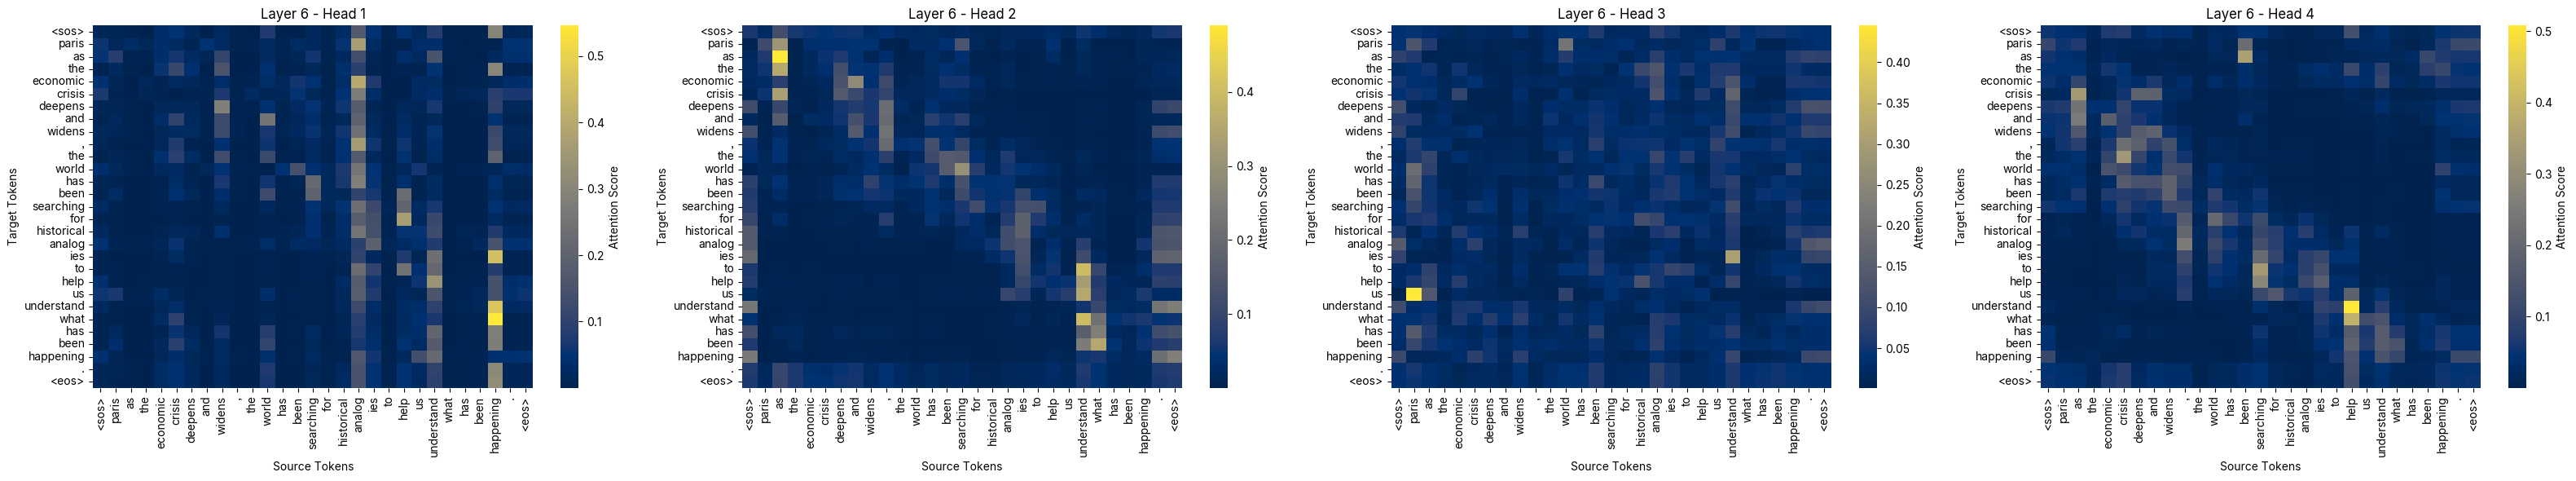

In [32]:
model.eval()
seq = "paris as the economic crisis deepens and widens, the world has been searching for historical analogies to help us understand what has been happening."
encoded = [tokenizer.bos_token_id] + tokenizer.encode(seq).ids + [tokenizer.eos_token_id]
input = torch.tensor(encoded, dtype=torch.long, device=device)  # (T1)
input = input.unsqueeze(0)  # (1, T1)
encoder_output, src_padding_mask, self_attns = model.encode(input, return_attn=True)
sequences = torch.ones(1, 1, dtype=torch.long, device=device) * tokenizer.bos_token_id
max_step = 50
top_k = 5
temperature = 0.5
src_tokens = ['<sos>'] + tokenizer.encode(seq).tokens + ['<eos>']
print(src_tokens)
visualize_all_attention(src_tokens, src_tokens, self_attns, cmap='cividis')

In [35]:
def visualize_encoder_token_similarities(encoder_output, src_tokens, cmap="RdBu"):
    # 获取第一个样本的编码器输出 [seq_len, hidden_dim]
    token_embeddings = encoder_output[0].cpu().detach()

    # 计算 L2 范数
    norms = torch.norm(token_embeddings, p=2, dim=1, keepdim=True)
    # 归一化向量
    normalized_embeddings = token_embeddings / norms

    # 计算余弦相似度矩阵 [seq_len, seq_len]
    cosine_similarities = torch.mm(normalized_embeddings, normalized_embeddings.t())

    # 创建图形
    plt.figure(figsize=(10, 8))

    # 绘制热力图
    sns.heatmap(
        cosine_similarities.numpy(),
        xticklabels=src_tokens,
        yticklabels=src_tokens,
        cmap=cmap,
        center=0,  # 将颜色中心点设为0
        vmin=-1,   # 余弦相似度范围为 [-1, 1]
        vmax=1,
        cbar_kws={'label': 'Cosine Similarity'}
    )

    # 设置标签
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.title('Token Representation Cosine Similarities')

    # 旋转标签以防重叠
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()


# visualize_encoder_token_similarities(encoder_output, src_tokens)

paris as the economic crisis deepens and widens, the world has been searching for historical analogies to help us understand what has been happening.
paris seeks to help us stabilisation analog ies
29 ['<sos>', 'paris', 'as', 'the', 'economic', 'crisis', 'deepens', 'and', 'widens', ',', 'the', 'world', 'has', 'been', 'searching', 'for', 'historical', 'analog', 'ies', 'to', 'help', 'us', 'understand', 'what', 'has', 'been', 'happening', '.', '<eos>']
9 ['<sos>', 'paris', 'seeks', 'to', 'help', 'us', 'stabilisation', 'analog', 'ies']
torch.Size([1, 9, 29])


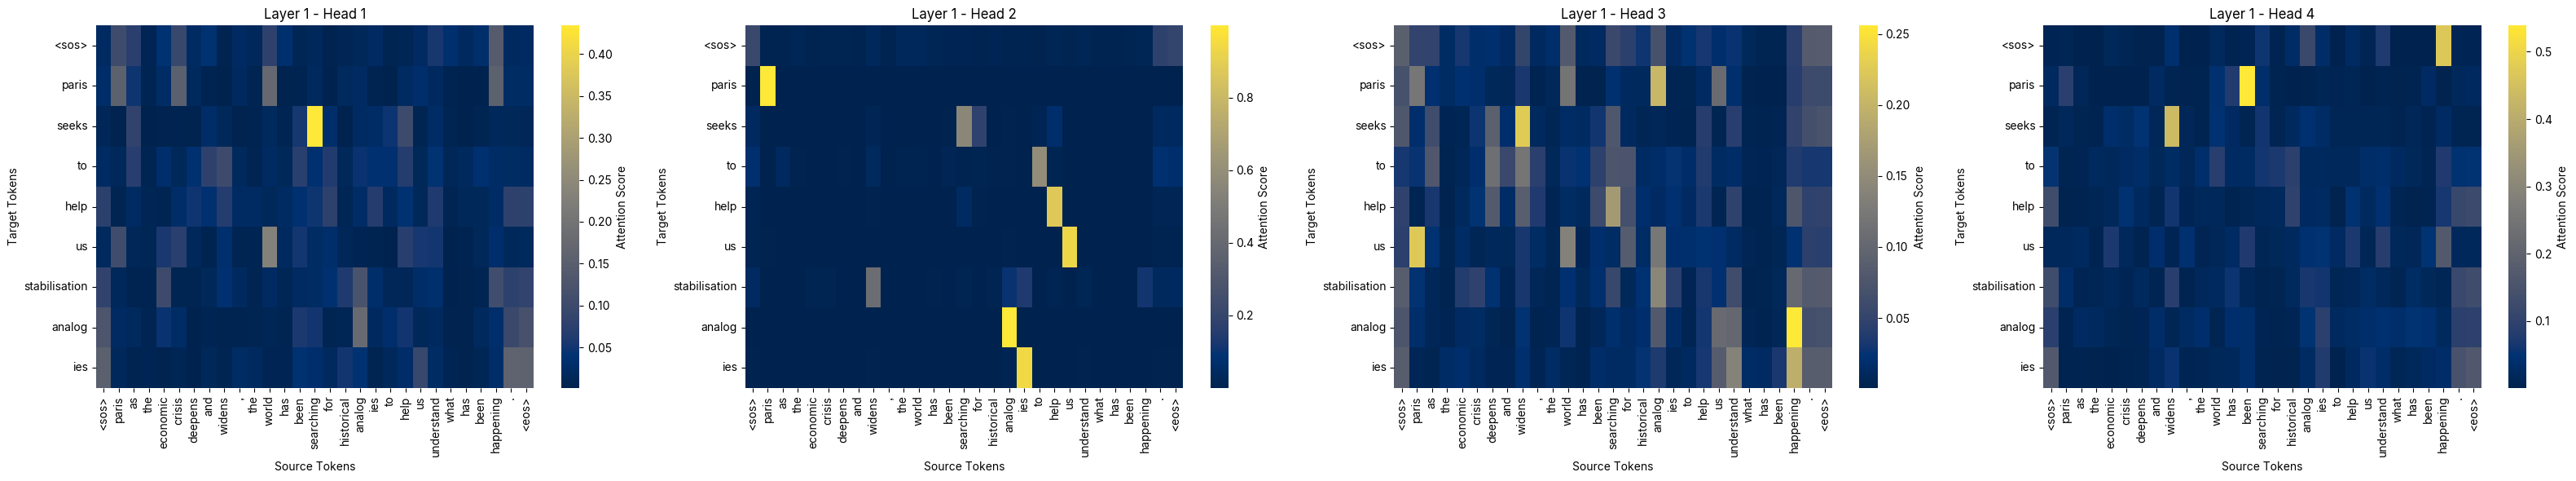

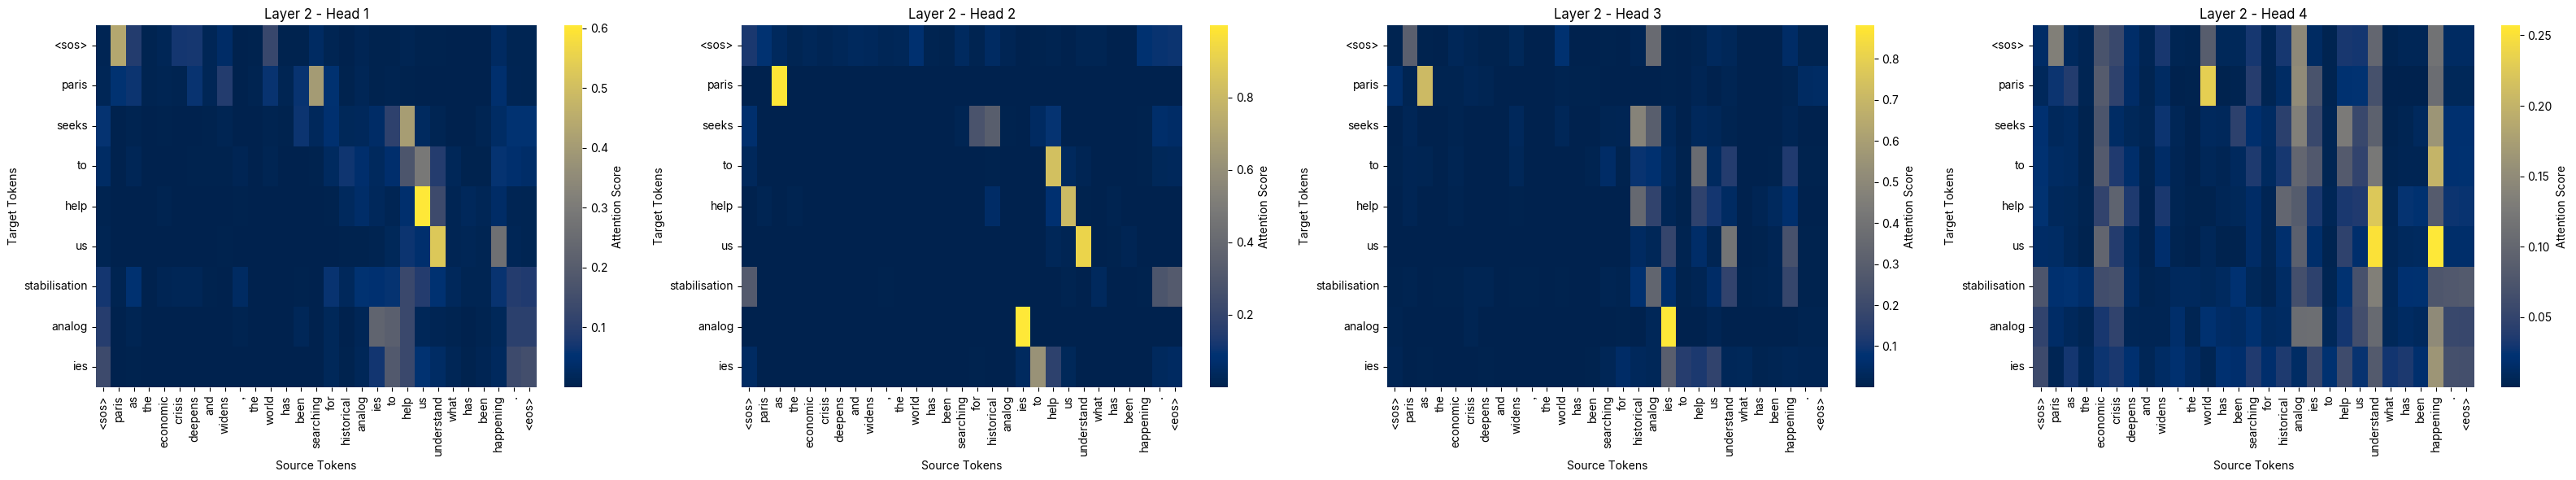

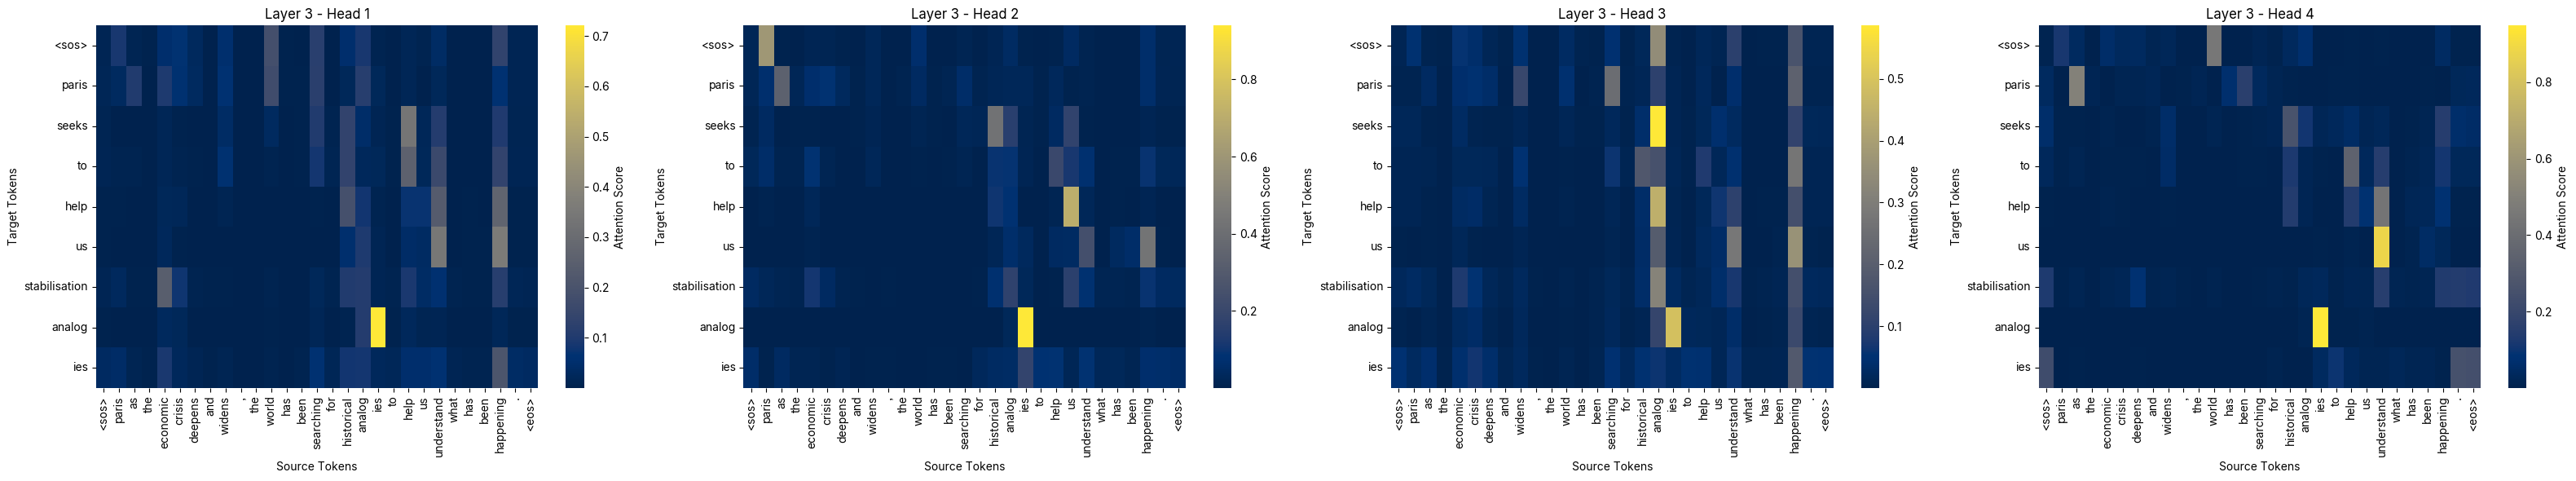

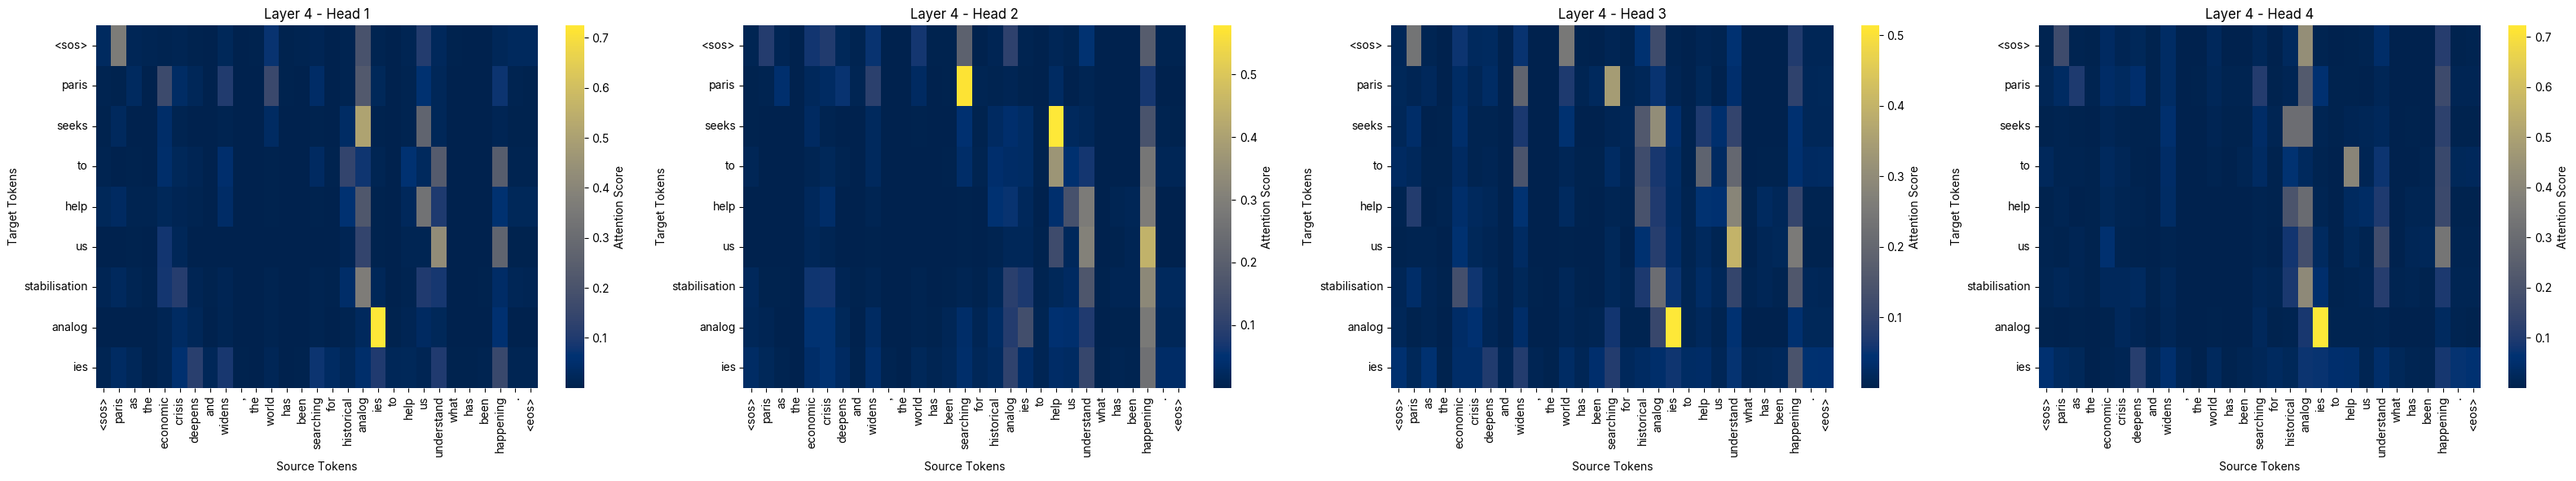

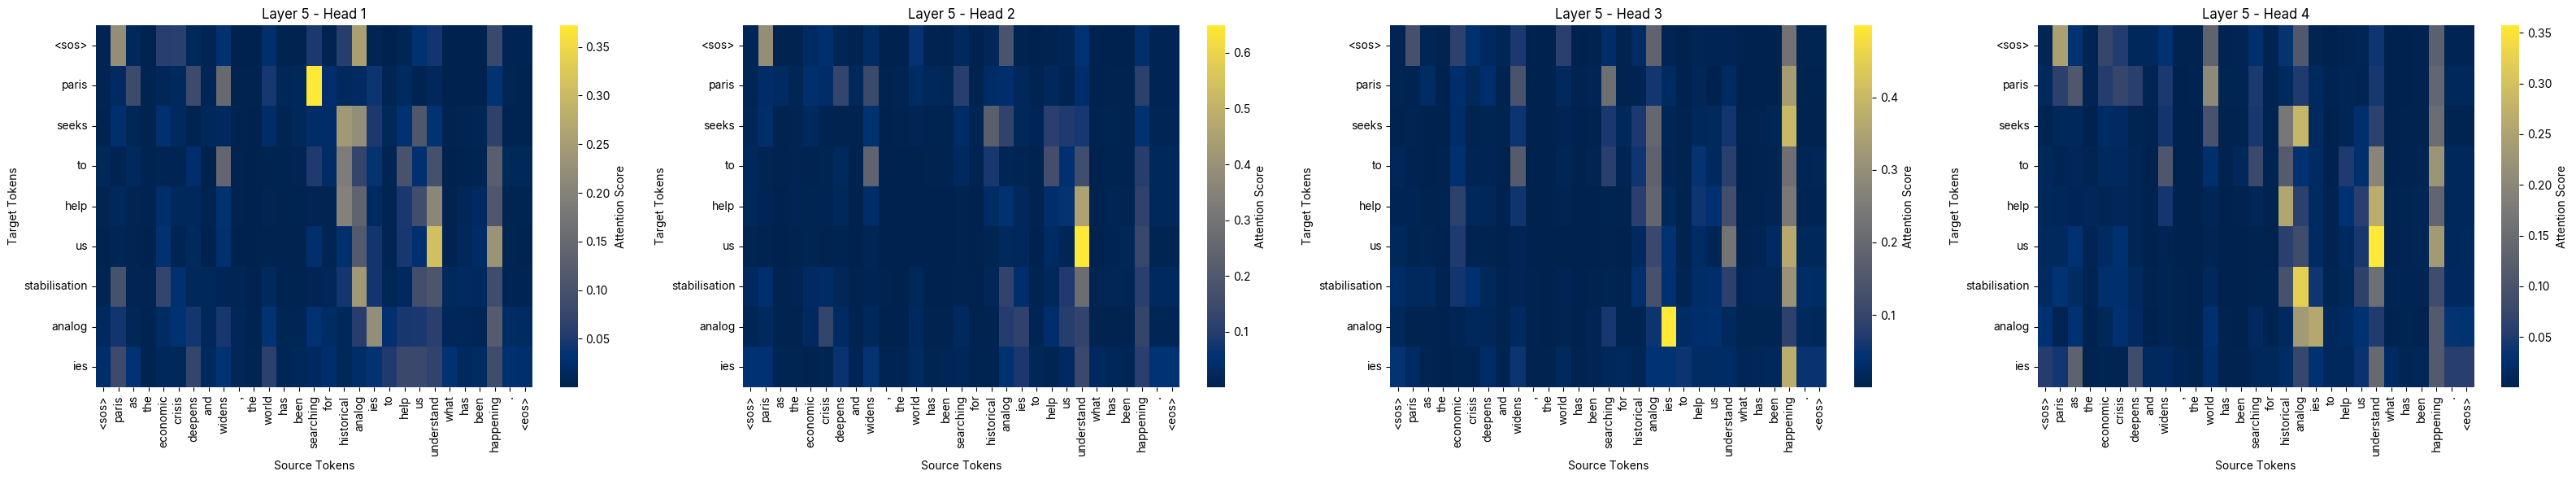

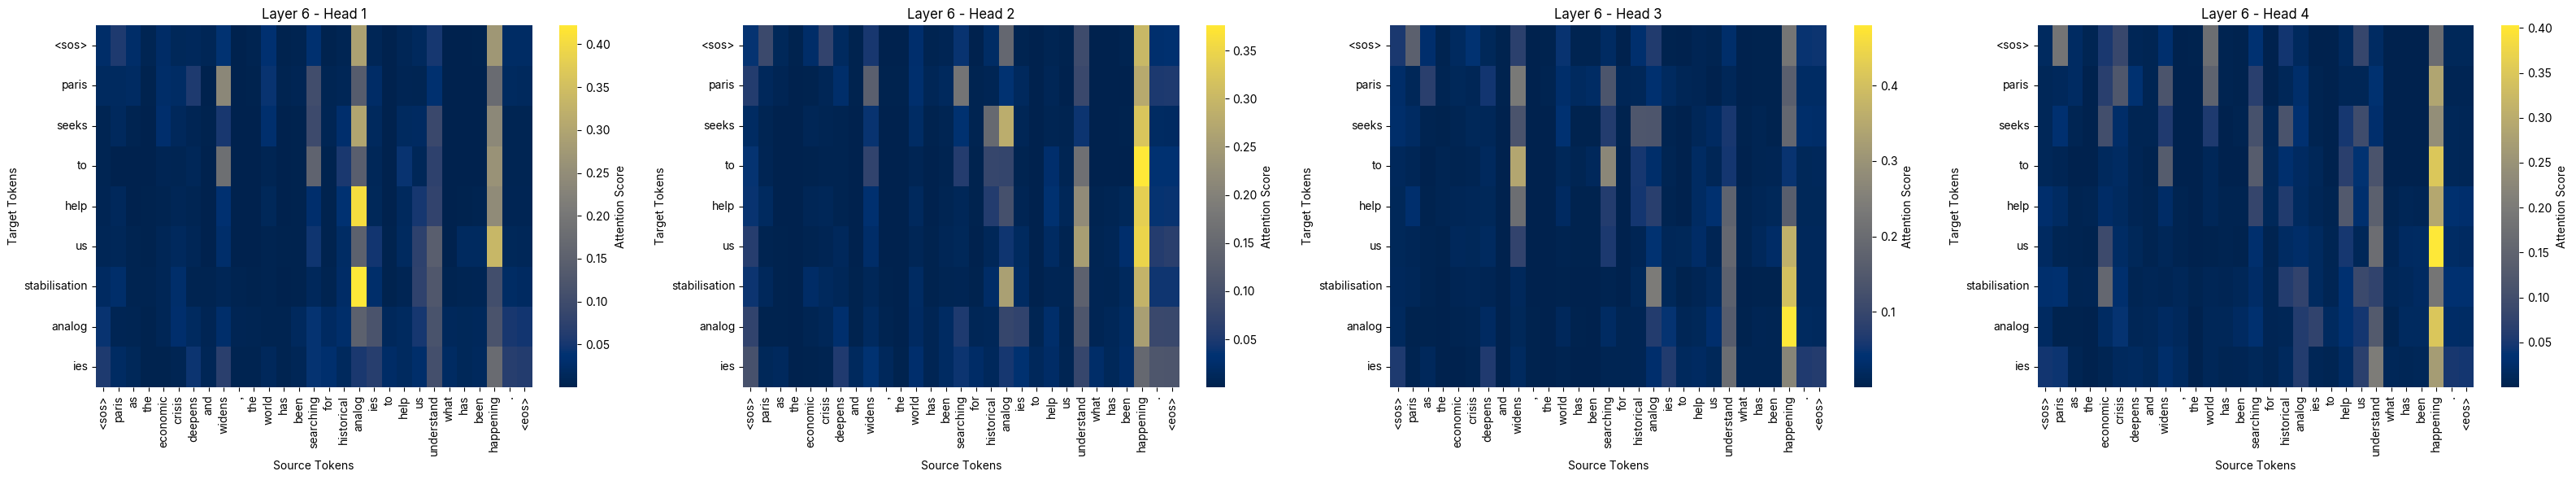

In [ ]:
steps_cross_attn_weights = []
for _ in range(max_step):
    logits, cross_attn_weights = model.decode(sequences, encoder_output, src_padding_mask, return_attn=True)
    logits = logits[:, -1, :] / temperature  # (1, vocab_size)
    topk_logits, top_k_indices = torch.topk(logits, k=min(top_k, logits.size(-1)))  # (1, k)
    probs = F.softmax(topk_logits, dim=-1)  # (1, k)
    next_token_idx = torch.multinomial(probs, num_samples=1)
    next_token = torch.gather(top_k_indices, 1, next_token_idx)
    sequences = torch.cat([sequences, next_token], dim=1)

    # break  # go one step
    steps_cross_attn_weights.append(cross_attn_weights)
    if sequences[0, -1].item() == tokenizer.eos_token_id:
        break

print(seq)
print(tokenizer.decode(sequences[0].tolist()))

hyp_tokens = ['<sos>'] + tokenizer.encode(tokenizer.decode(sequences[-1].tolist())).tokens
print(len(src_tokens), src_tokens)
print(len(hyp_tokens), hyp_tokens)
print(cross_attn_weights[0][0].shape)
# visualize_all_steps_attention(src_tokens, hyp_tokens, steps_cross_attn_weights, max_steps_to_plot=30)
visualize_all_attention(src_tokens, hyp_tokens, cross_attn_weights)

# Calc BLEU


In [22]:
# zh_en_data = load_dataset("wmt19", "zh-en", split=f"train[:30000]")
# print(zh_en_data.shape)
# print(zh_en_data.cache_files)

In [23]:
# filter_max_len = 50

# tokenized = []

# for i in zh_en_data:
#     text_zh = i['translation']['zh']
#     text_en = i['translation']['en']
#     zh = tokenize_zh(text_zh)
#     en = tokenize_en(text_en)
#     if len(zh) > filter_max_len or len(en) > filter_max_len:
#         continue
#     tokenized.append((en, zh))

In [24]:
def eval_by_bleu(model, tokenized, inference_args):
    bleu = evaluate.load('bleu')
    model.eval()
    with torch.no_grad():
        refs = []
        hyps = []
        batch_size = 32
        total_batches = (len(tokenized) + batch_size - 1) // batch_size
        print(total_batches)
        for batch_idx in range(total_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(tokenized))
            batch_data = tokenized[start_idx:end_idx]
            print(f"处理第 {batch_idx + 1}/{total_batches} 批数据 ({start_idx+1}-{end_idx}/{len(tokenized)})...", end="\r")
            # 准备批量数据
            src_texts = [" ".join(en) for en, _ in batch_data]
            ref_texts = [" ".join(zh) for _, zh in batch_data]

            # 批量翻译
            pred_texts = translate(model, src_texts, max_len, device, en_stoi, zh_itos, sos_token, eos_token, **inference_args)

            # 添加到评估列表
            for ref, pred in zip(ref_texts, pred_texts):
                refs.append([ref])
                hyps.append(pred)

        results = bleu.compute(predictions=hyps, references=refs)
        print("\n评估结果:")
        print(f"BLEU 分数: {results['bleu']*100:.1f}")

    return results


# score = eval_by_bleu(model, tokenized, inference_args={'method': 'top_k_sample', 'top_k': 5, 'temperature': 0.5})